<a href="https://colab.research.google.com/github/mehdihosseinimoghadam/Pytorch-Tutorial/blob/main/CNN_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torchaudio.transforms as transforms

In [2]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.Conv = nn.Sequential(
        nn.Conv2d(self.in_channels,
                  self.out_channels,
                  4,
                  2,
                  1),
        nn.BatchNorm2d(self.out_channels),
        nn.LeakyReLU()          
    )
  def forward(self, x):
    return self.Conv(x)  



class TransConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(TransConvBlock, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.Conv = nn.Sequential(
        nn.ConvTranspose2d(self.in_channels,
                  self.out_channels,
                  4,
                  2,
                  1),
        nn.BatchNorm2d(self.out_channels),
        nn.LeakyReLU()          
    )
  def forward(self, x):
    return self.Conv(x)  






class Encode(nn.Module):
  def __init__(self, in_channels, out_channels, latent_dim, filter_num_list=[2, 4, 8]):
    super(Encode, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.latent_dim = latent_dim
    self.filter_num_list = filter_num_list

    self.Conv = nn.Sequential(
        ConvBlock(self.in_channels, self.out_channels),
        ConvBlock(self.out_channels, self.out_channels * self.filter_num_list[0]),
        ConvBlock(self.out_channels * self.filter_num_list[0], self.out_channels * self.filter_num_list[1]),
        ConvBlock(self.out_channels * self.filter_num_list[1], self.out_channels * self.filter_num_list[2])
    )

    self.fc = nn.Linear(8 * self.out_channels * 2 * 2, self.latent_dim)
    self.mu = nn.Linear(self.latent_dim, self.latent_dim)
    self.logvar = nn.Linear(self.latent_dim, self.latent_dim)

  def forward(self, x):
    x = self.Conv(x)
    # print(x.shape)
    x = x.reshape(-1, 8 * self.out_channels * 2 * 2)
    x = self.fc(x)
    mu = self.mu(x)
    logvar = self.logvar(x)
    return mu, logvar


class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels, latent_dim, filter_num_list=[2,4,8]):
    super(Decoder, self).__init__() 
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.latent_dim = latent_dim
    self.filter_num_list = filter_num_list 

    self.DeConve = nn.Sequential(
        TransConvBlock(self.out_channels* self.filter_num_list[2] , self.out_channels * self.filter_num_list[1]),
        TransConvBlock(self.out_channels * self.filter_num_list[1], self.out_channels * self.filter_num_list[0]),
        TransConvBlock(self.out_channels * self.filter_num_list[0], self.out_channels ),
        TransConvBlock(self.out_channels , self.in_channels)
    )
    self.fc = nn.Linear(latent_dim, 8 * self.out_channels * 2 * 2)


  def reparameterezation(self, mu, logvar):
    eps = torch.randn_like(logvar)
    z = mu + eps*torch.exp(.5*logvar) 
    return z


  def forward(self, mu, logvar): 
    z = self.reparameterezation(mu, logvar)
    # print(z.shape)
    z = nn.functional.relu(z)
    # print(z.shape)
    x = nn.functional.relu(self.fc(z))
    # print(x.shape)
    x = x.reshape(-1, 8 * self.out_channels ,2,2)
    x = torch.sigmoid(self.DeConve(x))
    return x, mu, logvar







class VAE(nn.Module):
  def __init__(self, in_channels, out_channels, latent_dim, filter_num_list=[2,4,8]):
    super(VAE, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.latent_dim = latent_dim
    self.filter_num_list = filter_num_list

    self.Encoder = Encode(self.in_channels,  self.out_channels, self.latent_dim)
    self.Decoder = Decoder(self.in_channels, self.out_channels, self.latent_dim)


  def forward(self, x):
    mu, logvar = self.Encoder(x)
    x, mu, logvar = self.Decoder(mu, logvar)
    return x, mu, logvar

In [3]:
a = torch.rand(1,32,32).unsqueeze(0)
En = Encode(in_channels = 1, out_channels = 100, latent_dim = 1000)
En(a)[0].shape

torch.Size([1, 1000])

In [4]:
b = torch.rand(1,100)
De = Decoder(in_channels = 1, out_channels = 100, latent_dim = 100)
x, mu, logvar = De(b,b)
x.shape

torch.Size([1, 1, 32, 32])

In [5]:
vae = VAE(in_channels = 1, out_channels = 10, latent_dim = 100)
vae(a)

(tensor([[[[0.5469, 0.5426, 0.5611,  ..., 0.6105, 0.4990, 0.4994],
           [0.4995, 0.5297, 0.4994,  ..., 0.4993, 0.4987, 0.4994],
           [0.6009, 0.5826, 0.6163,  ..., 0.6832, 0.5281, 0.4998],
           ...,
           [0.4987, 0.5007, 0.4996,  ..., 0.6761, 0.4974, 0.5913],
           [0.5098, 0.4983, 0.6365,  ..., 0.4977, 0.5286, 0.4987],
           [0.4999, 0.5052, 0.4983,  ..., 0.4990, 0.4990, 0.5310]]]],
        grad_fn=<SigmoidBackward0>),
 tensor([[ 0.1733,  0.2791, -0.1811, -0.0950, -0.0926, -0.3299, -0.2135,  0.1051,
           0.0961, -0.3405, -0.1608,  0.1780, -0.2717,  0.2105,  0.1365,  0.2515,
           0.2264,  0.0020,  0.2624, -0.0402, -0.0755, -0.0776, -0.1312,  0.0909,
          -0.0853,  0.0661,  0.0688, -0.1139,  0.2145,  0.2020,  0.1184,  0.0879,
          -0.5361, -0.0523,  0.2523,  0.1877, -0.2849,  0.1673, -0.1476,  0.1046,
          -0.5129,  0.1414, -0.0374, -0.0999,  0.3610,  0.0007, -0.0788, -0.1807,
          -0.1413,  0.0632,  0.3722, -0.1436, -0.3

In [6]:
import torchvision.datasets as Datasets
import torchvision.transforms as transform
from torch.utils.data import DataLoader 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
trans = transform.Compose([
                           transform.ToTensor(),
                           transform.Resize(32)
])

In [8]:
train_data = Datasets.MNIST(root="/", train=True, transform=trans, download=True)
test_data = Datasets.MNIST(root="/", train=False, transform=trans, download=True)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /MNIST/raw/train-images-idx3-ubyte.gz to /MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST/raw



## Training

In [13]:
import torch.optim as optim
import torch.nn.functional as F
model = VAE(in_channels = 1, out_channels = 20, latent_dim = 64).to(device)
optimizer = optim.Adam(model.parameters(), lr=.0008)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 630507


In [14]:
def VAE_loss(recon_x, x, mu, logvar):
  loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
  kl_loss =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return loss + kl_loss  

In [15]:
num_epochs = 50
print_per = 100
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    print_loss = 0
    loss_record = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        loss = VAE_loss(recon_batch, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()
        if (i%print_per == 0):
            print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch+1, i, print_loss))
            loss_record.append(print_loss)
            print_loss = 0
    print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))

Epoch : 1 , Minibatch : 0 Loss = 14514.7139
Epoch : 1 , Minibatch : 100 Loss = 1157278.7803
Epoch : 1 , Minibatch : 200 Loss = 1135803.8438
Epoch : 1 , Minibatch : 300 Loss = 1135659.9932
Epoch : 1 , Minibatch : 400 Loss = 1135458.3877
Epoch : 1 , Minibatch : 500 Loss = 1135265.2910
Epoch : 1 , Minibatch : 600 Loss = 1135275.9570
Epoch : 1 , Minibatch : 700 Loss = 1135050.0068
Epoch : 1 , Minibatch : 800 Loss = 1134728.0518
Epoch : 1 , Minibatch : 900 Loss = 1134669.9639
Epoch : 1 , Minibatch : 1000 Loss = 1134504.7275
Epoch : 1 , Minibatch : 1100 Loss = 1134158.9512
Epoch : 1 , Minibatch : 1200 Loss = 1134052.9180
Epoch : 1 , Minibatch : 1300 Loss = 1133841.4355
Epoch : 1 , Minibatch : 1400 Loss = 1133779.5498
Epoch : 1 , Minibatch : 1500 Loss = 1133620.1182
Epoch : 1 , Minibatch : 1600 Loss = 1133039.9463
Epoch : 1 , Minibatch : 1700 Loss = 1133101.2275
Epoch : 1 , Minibatch : 1800 Loss = 1132844.4941
Epoch : 1 , Minibatch : 1900 Loss = 1132584.9463
Epoch : 1 , Minibatch : 2000 Loss 

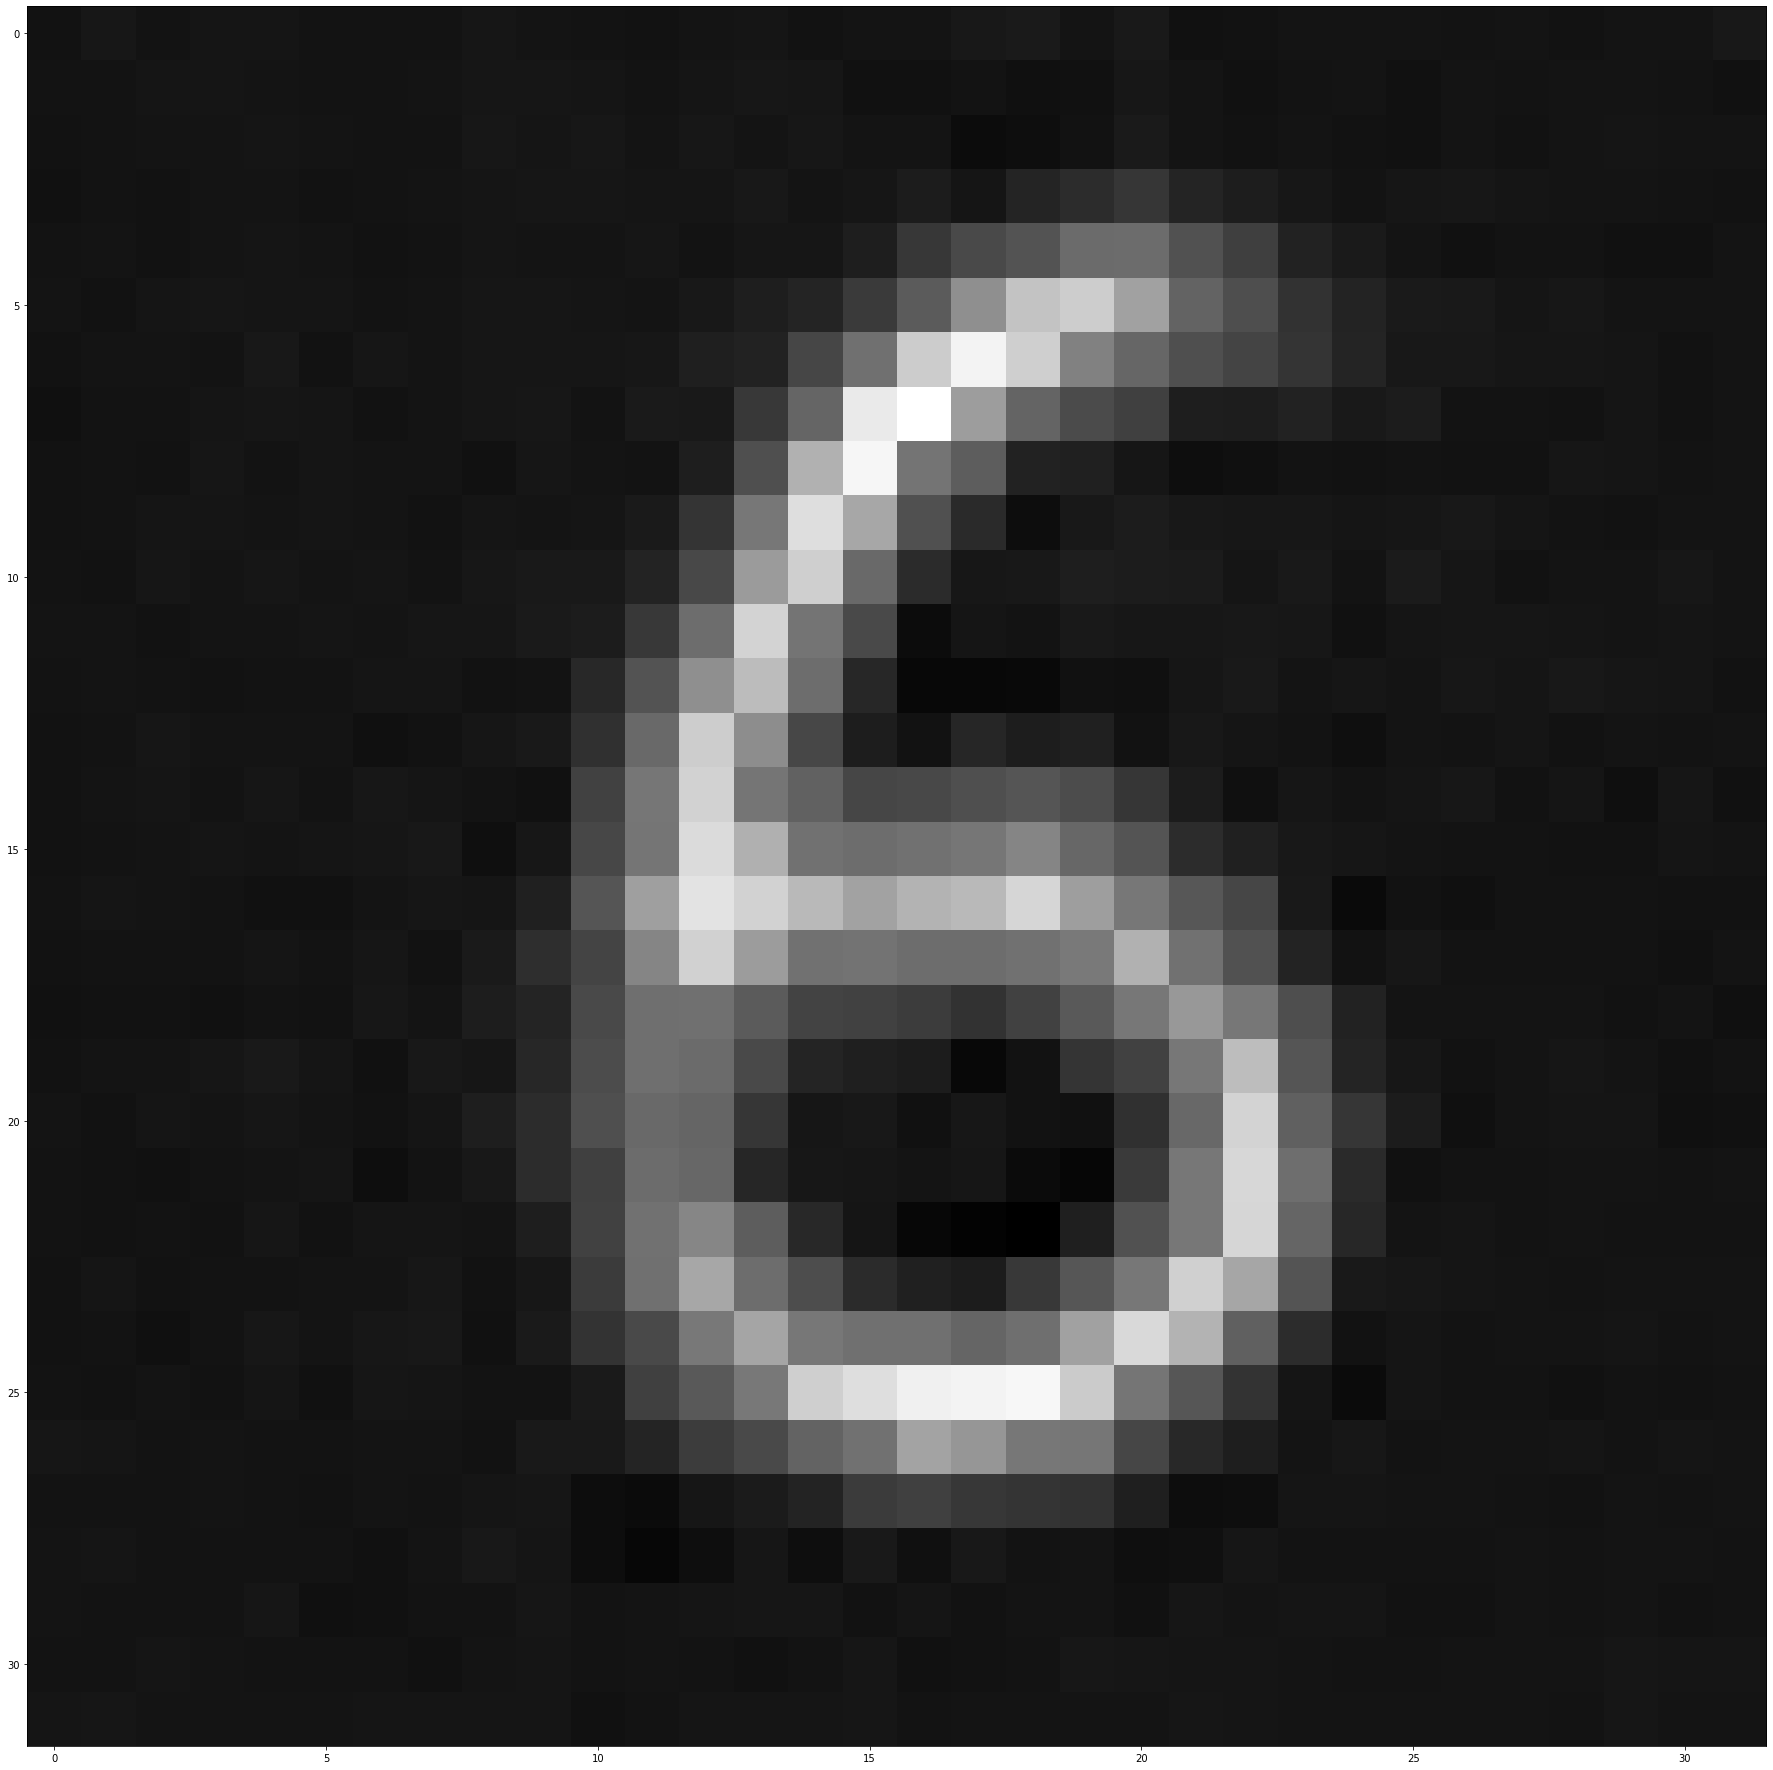

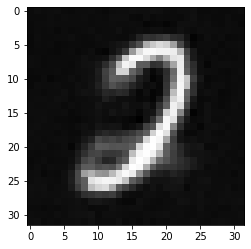

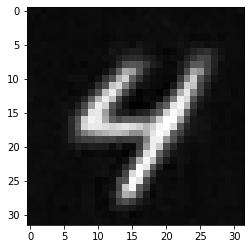

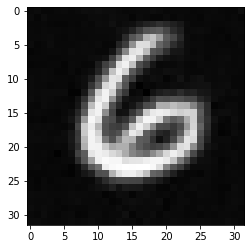

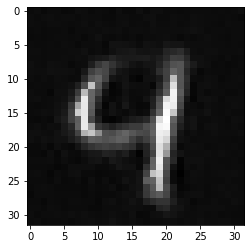

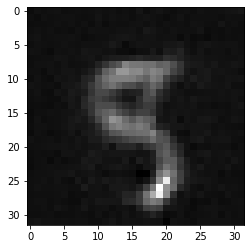

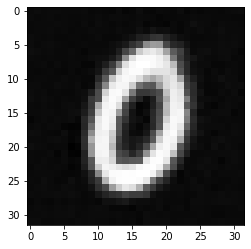

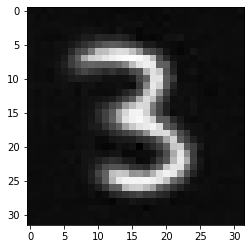

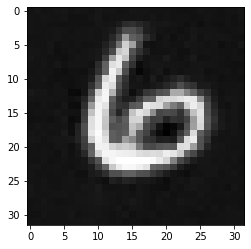

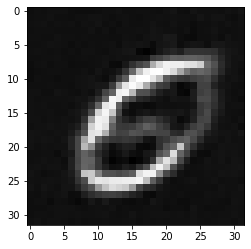

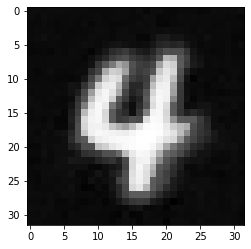

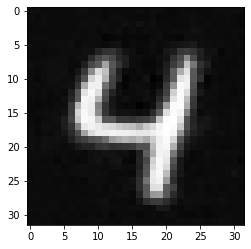

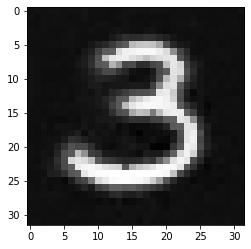

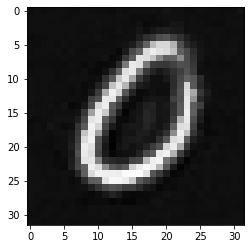

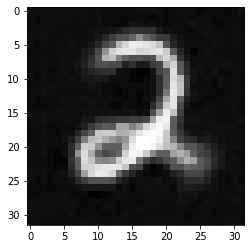

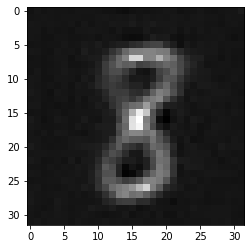

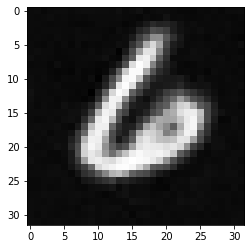

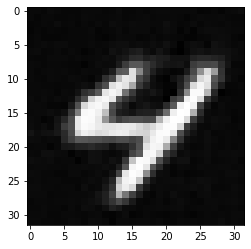

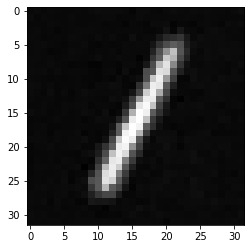

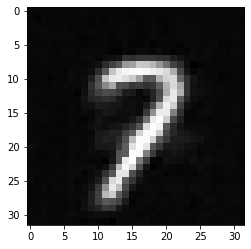

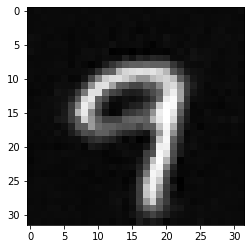

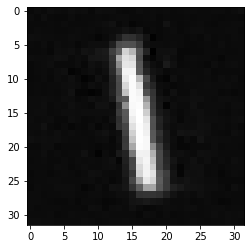

KeyboardInterrupt: ignored

In [16]:
import matplotlib.pyplot as plt
test_loss = 0
print_per = 10
fig=plt.figure(figsize=(32, 32))
columns = 2
rows = 5
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)
        recon_batch, mu, logvar = model(images)
        test_loss += VAE_loss(recon_batch, images, mu, logvar).item()
        if (i%print_per == 0):
            plt.imshow(model(images)[0].data[0].cpu().numpy().reshape(32, 32), cmap='gray')
            plt.show(block=True)

## Scheduled Loss

In [21]:
import torch.optim as optim
import torch.nn.functional as F
model = VAE(in_channels = 1, out_channels = 10, latent_dim = 1024).to(device)
optimizer = optim.Adam(model.parameters(), lr=.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 2891287


In [22]:
def VAE_loss(recon_x, x, mu, logvar):
  loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
  kl_loss =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return loss + kl_loss  

In [23]:
num_epochs = 20
print_per = 100
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    print_loss = 0
    loss_record = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        loss = VAE_loss(recon_batch, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        scheduler.step(train_loss)
        print_loss += loss.item()
        optimizer.step()
        if (i%print_per == 0):
            print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch+1, i, print_loss))
            loss_record.append(print_loss)
            print_loss = 0
    print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))



#     Epoch : 1 , Minibatch : 0 Loss = 14884.0566
# Epoch : 1 , Minibatch : 100 Loss = 1168443.3594
# Epoch : 1 , Minibatch : 200 Loss = 1135774.9463
# Epoch : 1 , Minibatch : 300 Loss = 1135600.8574
# Epoch : 1 , Minibatch : 400 Loss = 1135500.5225
# Epoch : 1 , Minibatch : 500 Loss = 1135432.1914
# Epoch : 1 , Minibatch : 600 Loss = 1135353.0713
# Epoch : 1 , Minibatch : 700 Loss = 1135305.6758
# Epoch : 1 , Minibatch : 800 Loss = 1135193.2715
# Epoch : 1 , Minibatch : 900 Loss = 1135094.1934
# Epoch : 1 , Minibatch : 1000 Loss = 1135017.1797
# Epoch : 1 , Minibatch : 1100 Loss = 1134909.8125
# Epoch : 1 , Minibatch : 1200 Loss = 1134781.5771
# Epoch : 1 , Minibatch : 1300 Loss = 1134661.3311
# Epoch : 1 , Minibatch : 1400 Loss = 1134541.6875

Epoch : 1 , Minibatch : 0 Loss = 14941.3340
Epoch : 1 , Minibatch : 100 Loss = 10698696.5430
Epoch : 1 , Minibatch : 200 Loss = 6988507.4727
Epoch : 1 , Minibatch : 300 Loss = 6914526.6445
Epoch : 1 , Minibatch : 400 Loss = 6870655.3047
Epoch : 1 , Minibatch : 500 Loss = 6844077.1602
Epoch : 1 , Minibatch : 600 Loss = 6803766.5664
Epoch : 1 , Minibatch : 700 Loss = 6938319.5859
Epoch : 1 , Minibatch : 800 Loss = 6879658.2930
Epoch : 1 , Minibatch : 900 Loss = 6927363.9102
Epoch : 1 , Minibatch : 1000 Loss = 6883360.9141
Epoch : 1 , Minibatch : 1100 Loss = 6901619.9375
Epoch : 1 , Minibatch : 1200 Loss = 6888249.3672
Epoch : 1 , Minibatch : 1300 Loss = 6870398.0078
Epoch : 1 , Minibatch : 1400 Loss = 6888727.3594
Epoch : 1 , Minibatch : 1500 Loss = 6918734.2422
Epoch : 1 , Minibatch : 1600 Loss = 6876637.3359
Epoch : 1 , Minibatch : 1700 Loss = 6883641.3242
Epoch : 1 , Minibatch : 1800 Loss = 6883758.8711
Epoch : 1 , Minibatch : 1900 Loss = 6880211.8750
Epoch : 1 , Minibatch : 2000 Loss

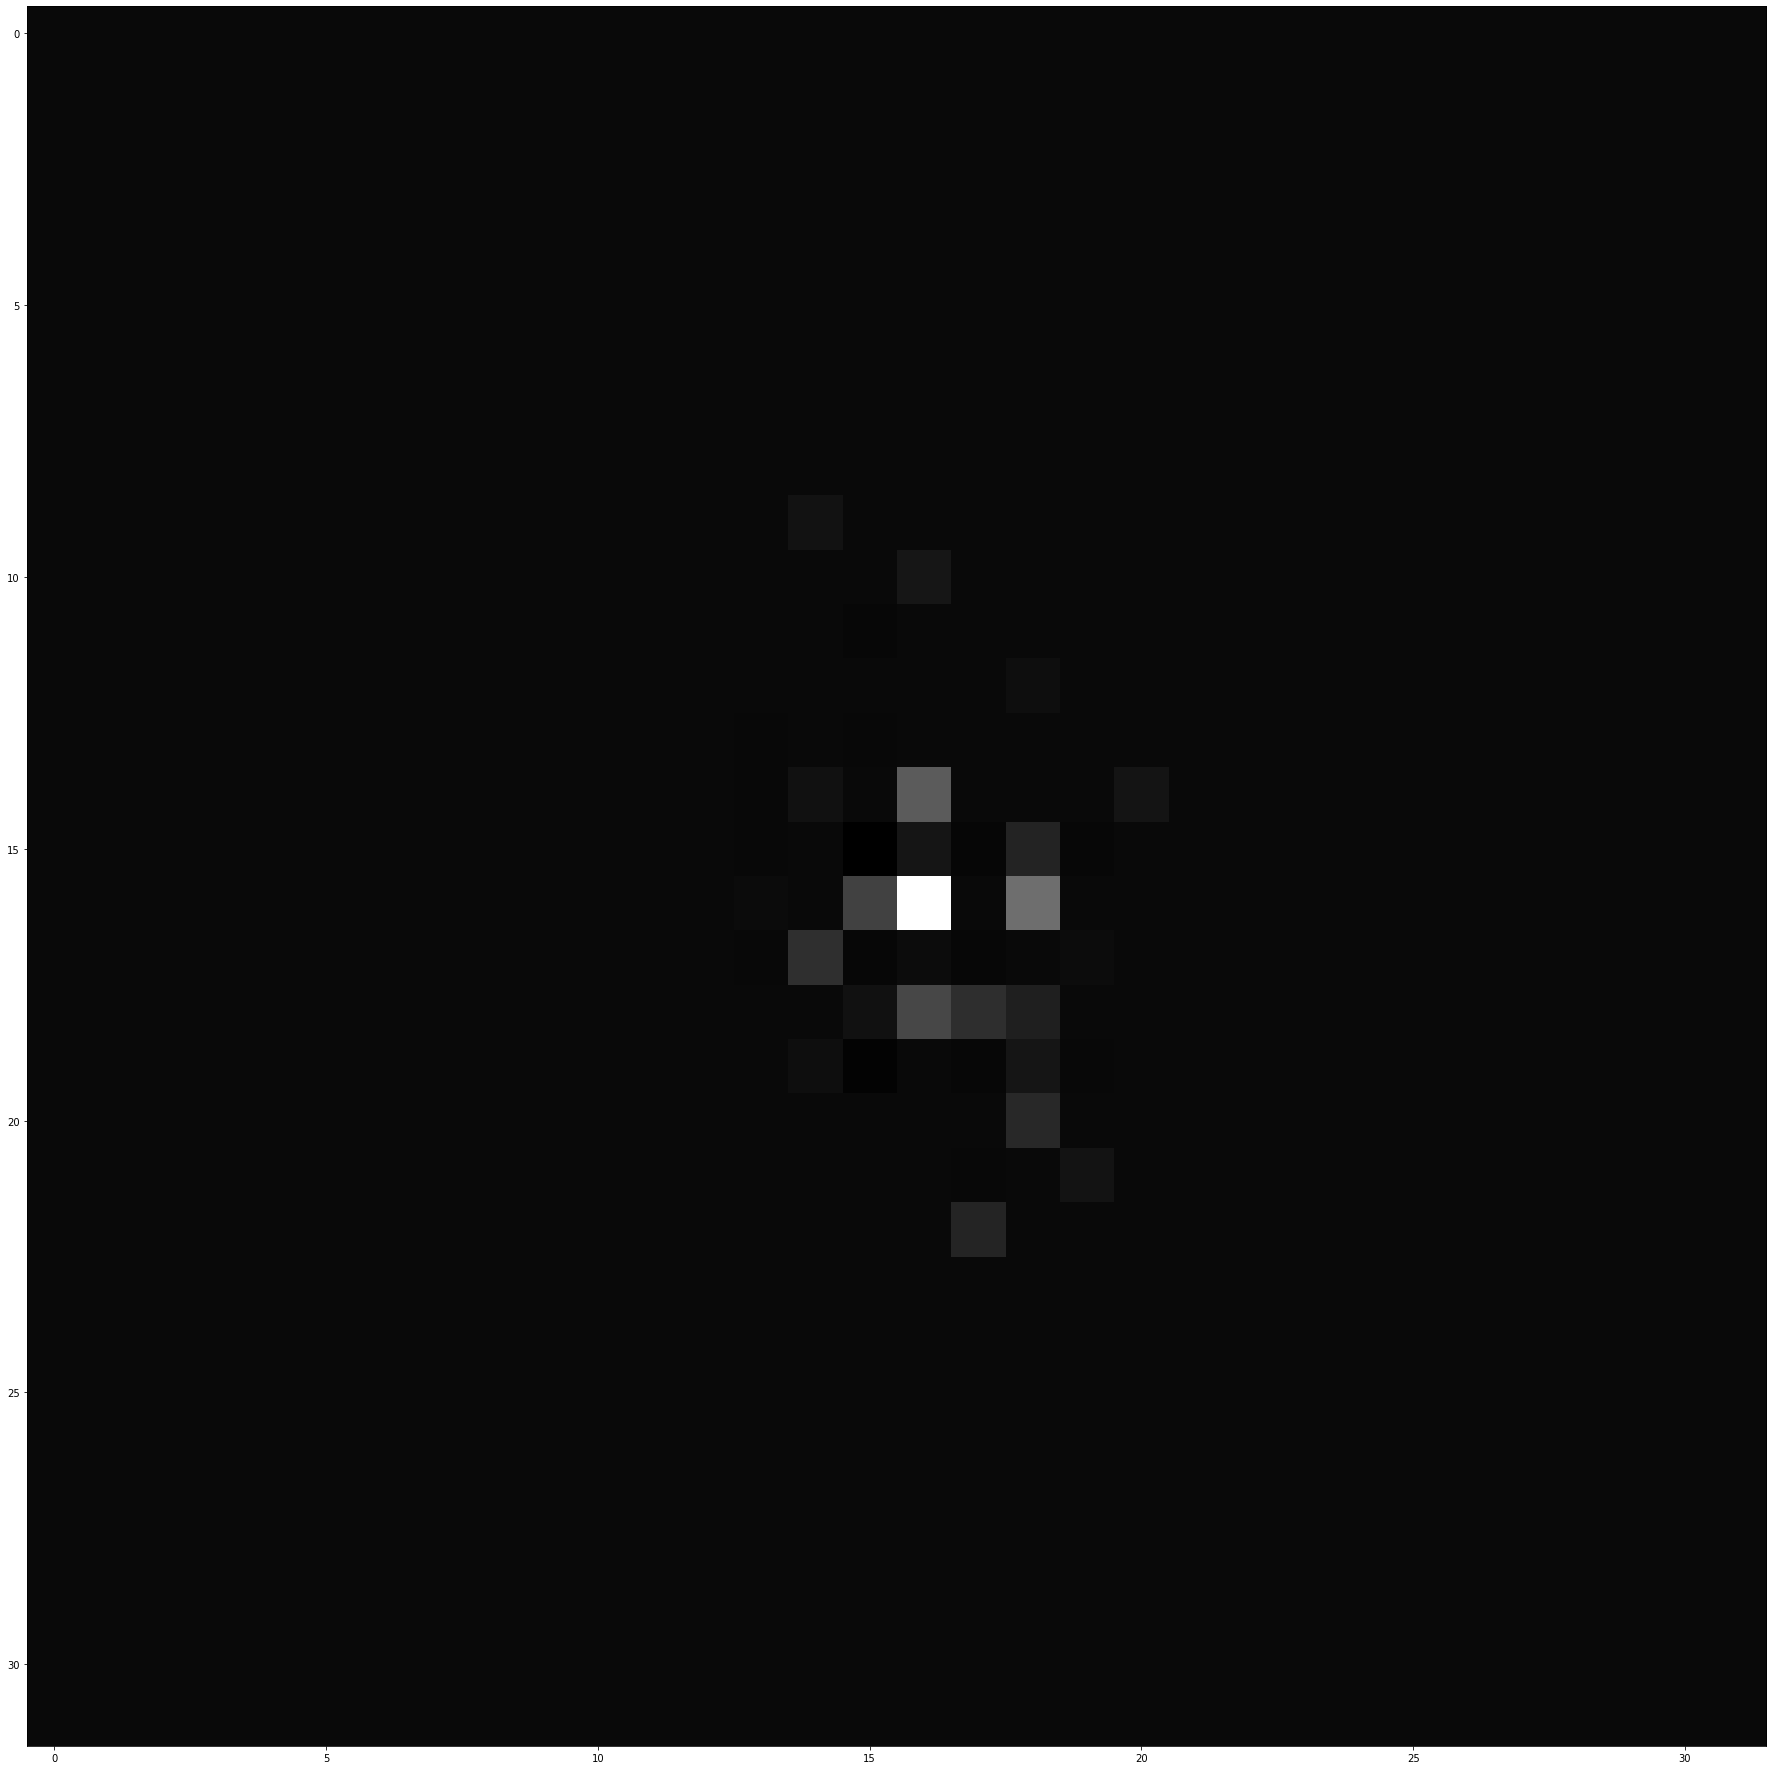

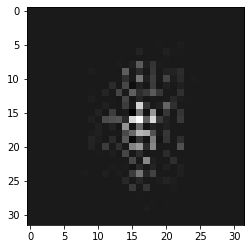

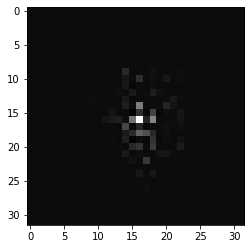

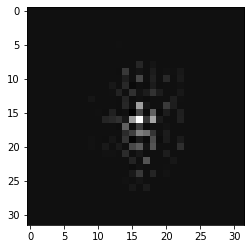

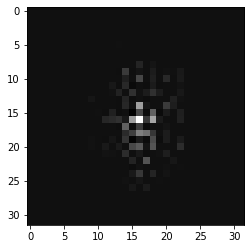

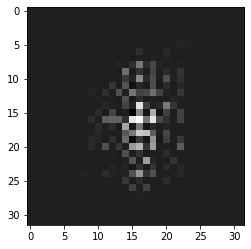

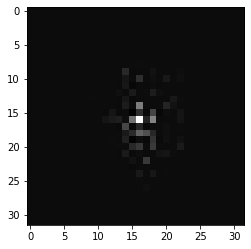

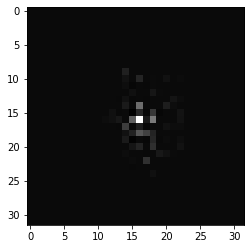

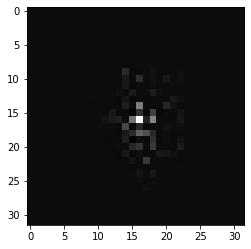

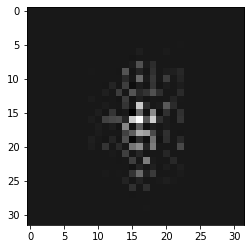

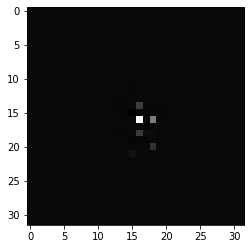

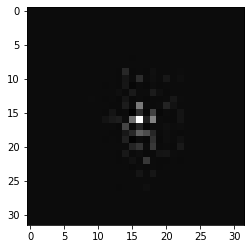

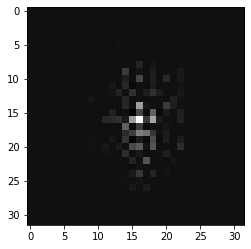

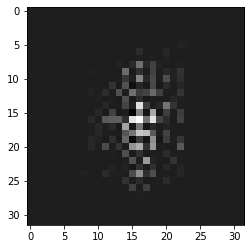

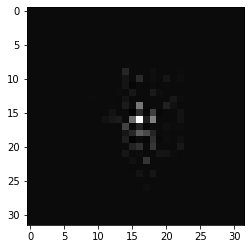

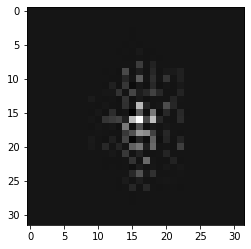

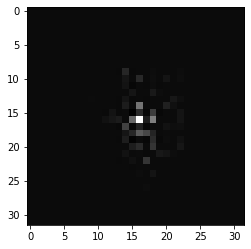

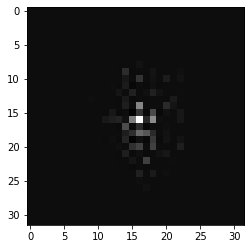

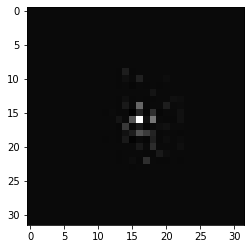

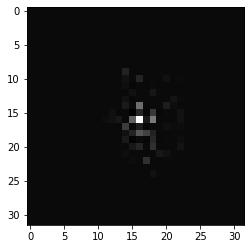

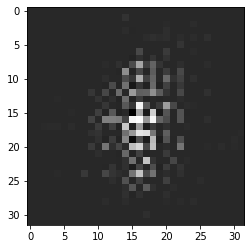

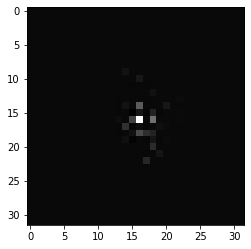

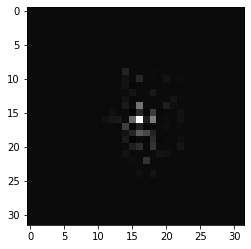

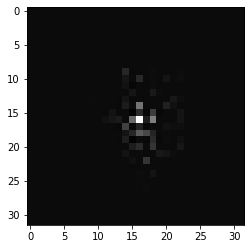

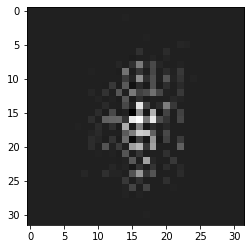

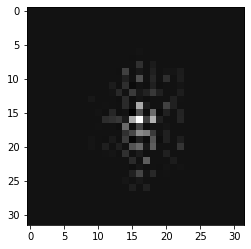

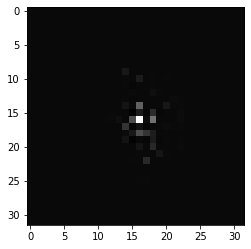

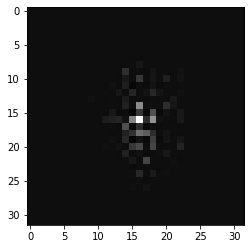

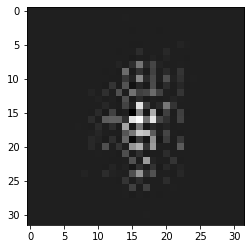

KeyboardInterrupt: ignored

In [24]:
import matplotlib.pyplot as plt
test_loss = 0
print_per = 10
fig=plt.figure(figsize=(32, 32))
columns = 2
rows = 5
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)
        recon_batch, mu, logvar = model(images)
        test_loss += VAE_loss(recon_batch, images, mu, logvar).item()
        if (i%print_per == 0):
            plt.imshow(model(images)[0].data[0].cpu().numpy().reshape(32, 32), cmap='gray')
            plt.show(block=True)